In [2]:
import os
import sys

In [3]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [4]:


if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    
    # code required by Colab
    %cd /content/drive/MyDrive/PatMatBaselineAlena
    
    root_dir = '/content/drive/MyDrive/PatMatBaselineAlena'
else:
    root_dir = '..'
    %cd ..

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena


c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena


In [6]:
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), root_dir))
sys.path.append(current_dir)

In [7]:
# install requirements
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import json
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from datetime import datetime
import mlflow

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# # this code uploads the credentials to MLflow given in the .env file
from src.settings import (
    MLFLOW_TRACKING_URI,
    MLFLOW_TRACKING_USERNAME,
    MLFLOW_TRACKING_PASSWORD,
    path_1
)

In [10]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [11]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cpu')

In [13]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Move the model to the proper device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
def load_jsonl(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('data/train_v2.jsonl')
validation_data = load_jsonl('data/test_v2.jsonl')

# Prepare the texts and labels
train_texts = [(item['text'], item['text_b']) for item in train_data]
train_labels = [item['label'] for item in train_data]
validation_texts = [(item['text'], item['text_b']) for item in validation_data]
validation_labels = [item['label'] for item in validation_data]

In [17]:
len(train_texts), len(train_labels), len(validation_texts), len(validation_labels)

(2920, 2920, 730, 730)

In [18]:
# If you don't have a GPU, limit the amount of data
if device.type == 'cpu':
    train_texts = train_texts[:20]
    train_labels = train_labels[:20]
    validation_texts = validation_texts[:20]
    validation_labels = validation_labels[:20]

In [19]:
# Define a dictionary with model configuration and hyperparameters
# Consider changing the number of epochs if you want to observe longer training
config = {
    'learning_rate': 2e-5,
    'batch_size': 32,
    'num_epochs': 10,
    'max_length': 512,
    'test_size': 0.2,
    'random_state': 42,
}

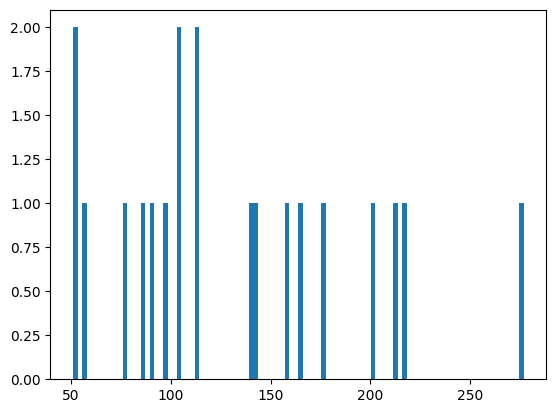

In [20]:
doc1_and_doc2 = []

for item in validation_texts:
    doc1_and_doc2.append(item[0] + " " + item[1])

# Visualize the distribution of the length of the 2 documents combined together
import matplotlib.pyplot as plt
plt.hist([len(item.split()) for item in doc1_and_doc2], bins=100)
plt.show()

In [21]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])

train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']
validation_input_ids = validation_encodings['input_ids']
validation_attention_mask = validation_encodings['attention_mask']

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

In [22]:
train_input_ids.shape, train_attention_mask.shape, validation_input_ids.shape, validation_attention_mask.shape

(torch.Size([20, 341]),
 torch.Size([20, 341]),
 torch.Size([20, 339]),
 torch.Size([20, 339]))

In [23]:
train_labels.shape, validation_labels.shape

(torch.Size([20]), torch.Size([20]))

In [24]:
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
validation_data = TensorDataset(validation_input_ids, validation_attention_mask, validation_labels)


In [25]:
train_data.tensors[0].shape, train_data.tensors[1].shape, train_data.tensors[2].shape

(torch.Size([20, 341]), torch.Size([20, 341]), torch.Size([20]))

In [26]:
validation_data.tensors[0].shape, validation_data.tensors[1].shape, validation_data.tensors[2].shape

(torch.Size([20, 339]), torch.Size([20, 339]), torch.Size([20]))

In [27]:
train_dataloader = DataLoader(train_data, batch_size=config["batch_size"])
validation_dataloader = DataLoader(validation_data, batch_size=config["batch_size"])


In [28]:
for batch in train_dataloader:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([20, 341]) torch.Size([20, 341]) torch.Size([20])


In [29]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], no_deprecation_warning=True)

In [30]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [31]:
# This variable along with the timestamp will be used to create the name of the experiment run. By default, this is the MLflow username, but you can change it as you like.
user = MLFLOW_TRACKING_USERNAME
# This variable will be the name of the folder in MLflow. You can change it as you wish.
# If you provide the name of an already existing experiment, the experiment runs will be saved in the specified folder.
# If you provide the name of a non-existent experiment, you will create a new folder with the given name.
experiment_name = 'Alena_PatentMatchBaseline'


def timestamp():
    """This function creates current timestamp"""
    return datetime.now().strftime("%Y_%m_%d_%H%M_%S")

In [32]:
# If you have provided the name of an experiment that does not exist or that existed in MLflow but was deleted, create a new experiment.
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None or experiment.lifecycle_stage == 'deleted':
    mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [ ]:
# def compute_metrics(eval_pred):
#     print(eval_pred)
#     f1_score = datasets.load_metric("f1")
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     f1_score.add_batch(predictions=predictions, references=labels)
#     return f1_score.compute()

In [33]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
  for param_name, param_value in config.items():
    mlflow.log_param(param_name, param_value)

  for epoch in range(config['num_epochs']):  # Number of training epochs
    # set run name
    mlflow.set_tag(key='mlflow.runName',
                    value=f'{timestamp()}_{user}')
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        print(batch[0].shape, batch[1].shape, batch[2].shape)
        b_input_ids, b_attention_mask, b_labels = batch

        # Move the batch to the proper device
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)

        model.zero_grad()
        print(b_labels)
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        print(outputs.logits)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Log the average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
    print(f"Average training loss for epoch {epoch}: {avg_train_loss}")

    # Validation loop
    model.eval()
    predictions, true_labels = [], []
    for batch in validation_dataloader:
        b_input_ids, b_attention_mask, b_labels = batch

        # Move the batch to the proper device
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)
        b_attention_mask = b_attention_mask.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask)

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
        true_labels.extend(b_labels.cpu().tolist())

    # Calculate the accuracy of the predictions
    val_accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Accuracy: {val_accuracy}")

    # Log the validation accuracy for the epoch
    mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    cm_filename = f"artifacts/{timestamp()}_confusion_matrix_epoch_{epoch}.csv"
    np.savetxt(cm_filename, cm, delimiter=",")
    mlflow.log_artifact(cm_filename)

    # Print the confusion matrix
    print(cm)
mlflow.end_run()

torch.Size([20, 341]) torch.Size([20, 341]) torch.Size([20])
tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])
tensor([[-0.2593,  0.3401],
        [-0.3196, -0.1891],
        [-0.3000, -0.1774],
        [-0.2265,  0.0994],
        [-0.4764,  0.2024],
        [-0.5439, -0.0395],
        [-0.2467, -0.2450],
        [-0.3221,  0.2159],
        [-0.2093,  0.0906],
        [-0.1749,  0.0848],
        [-0.4428,  0.3234],
        [-0.0526,  0.1827],
        [-0.3913,  0.2450],
        [-0.0517,  0.4814],
        [-0.2095, -0.0612],
        [-0.3176, -0.0777],
        [-0.3051, -0.3655],
        [-0.1868,  0.1156],
        [-0.1846, -0.0462],
        [-0.2028,  0.2527]], grad_fn=<AddmmBackward0>)
Average training loss for epoch 0: 0.6511324644088745
Validation Accuracy: 0.8
[[ 0  4]
 [ 0 16]]
torch.Size([20, 341]) torch.Size([20, 341]) torch.Size([20])
tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])
tensor([[-0.1596,  0.0770],
        [-0.5229, -0.3002],